In [3]:
# Z-correlation for a whole session, frame by frame (don't do it if it's already there)
from ScanImageTiffReader import ScanImageTiffReader
from suite2p import registration
import json
import tifffile
import os
import numpy as np
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")
setup = 'Bergamo-2P-Photostim'
fov = 'FOV_02'
subject = 'PKJ_01'
for session in ['050923','051023']:


    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    if os.path.exists(os.path.join(session_dir,'zcorr.npy')):
        print('{} already exported'.format(session))
        continue
    with open(os.path.join(session_dir,'s2p_params.json')) as f:
        s2p_params = json.load(f)
    zstack_path = os.path.join(session_dir,s2p_params['z_stack_name'])
    try:
        reader=ScanImageTiffReader(zstack_path)
        stack=reader.data()
    except:
        stack = tifffile.imread(zstack_path)
    ops = np.load(os.path.join(session_dir,'ops.npy'),allow_pickle = True).tolist()
    ops['reg_file'] = os.path.join(session_dir,'data.bin')
    ops['nframes'] = np.sum(ops['nframes_list'])
    ops_orig, zcorr = registration.zalign.compute_zpos(stack, ops)
    np.save(os.path.join(session_dir,'zcorr.npy'),zcorr)


050923 already exported
051023 already exported


In [4]:
import numpy as np
import BCI_analysis
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def Gauss(x, A, B,C): # function for estimating the Z offset
    y = A*np.exp(-1*B*(x+C)**2)
    return y

use_scalar_f0 = False

sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
fov = 'FOV_02'
subject = 'PKJ_01'
add_shifts = True

files = os.listdir(os.path.join(sessionwise_base_dir,subject))
stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
#stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
sessions = []
data_dict = {}

for file in files[-5:]: ### NOT ALL FILES?? - 
    if fov in file:
        session = file[len(subject)+1:-1*(len(fov)+5)]
        sessions.append(session)
        data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
        #data_dict[session] = np.load(os.path.join(sessionwise_base_dir,subject,file),allow_pickle = True).tolist()
        F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
        if add_shifts:
            ops =  np.load(os.path.join(s2p_base_dir,subject,fov,session, "ops.npy") ,allow_pickle = True).tolist()
            data_dict[session]['rigid_y_offset'] = ops['yoff_list']
            data_dict[session]['rigid_x_offset'] = ops['xoff_list']
            #data_dict[session]['nonrigid_y_offset'] = ops['yoff1_list']
            #data_dict[session]['nonrigid_x_offset'] = ops['xoff1_list']
            data_dict[session]['z_matrix'] = np.load(os.path.join(s2p_base_dir,subject,fov,session,'zcorr.npy'))
            
            parameter_list = []
            error_list = []
            xdata = np.arange(data_dict[session]['z_matrix'].shape[0])-data_dict[session]['z_matrix'].shape[0]/2
            for ydata in data_dict[session]['z_matrix'].T:
                ydata = ydata.flatten()#data_dict[session]['z_matrix'][:,120].flatten()
                try:
                    parameters, covariance = curve_fit(Gauss, xdata, ydata)
                except:
                    parameters = [np.nan]*3

                fit_y = Gauss(xdata, parameters[0], parameters[1],parameters[2])
                error_list.append(np.sum(np.abs(ydata-fit_y)))
                parameter_list.append(parameters)
            data_dict[session]['rigid_z_offset_raw'] = np.argmax(data_dict[session]['z_matrix'],0)-data_dict[session]['z_matrix'].shape[0]/2
            data_dict[session]['rigid_z_offset_fit'] = np.asarray(parameter_list)[:,2]*-1
        #asdas
        data_dict[session]['F0'] = F0
        if use_scalar_f0:
            data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
        #data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
        data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
        reward_collecting_lick_times = []
        for reward_t,lick_t in zip(data_dict[session]['reward_times'],data_dict[session]['lick_times']):
            if len(reward_t) == 0:
                reward_collecting_lick_times.append(np.asarray([]))
            else:
                
                if any(lick_t>reward_t):
                    reward_collecting_lick_times.append(np.asarray([lick_t[np.argmax(lick_t>reward_t)]]))
                else:
                    reward_collecting_lick_times.append(np.asarray([]))
        data_dict[session]['reward_collecting_lick_times'] = np.asarray(reward_collecting_lick_times)
        # data_dict[session]['closed_loop_filenames'] = []
        # for fn in data_dict[session]['all_si_filenames']:
        #     if 'conditioning' in fn:
        #         data_dict[session]['closed_loop_filenames'].append(fn)
        print(file)

/tmp/ipykernel_6591/1458308275.py:9: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x+C)**2)


PKJ_01-050923-FOV_02.npy
PKJ_01-051023-FOV_02.npy


In [5]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)


In [28]:
fig.tight_layout()


array([ 200,  200,  200,  200,  200,  200,  600,  600,  600,  600,  600,
        600,  422,  631,  769,  431, 1001,  663,  520,  722,  898,  550,
        436,  463,  631,  426,  666,  928,  786,  426,  803,  762,  795,
        812,  723,  684,  464,  426, 1159,  484,  626,  695,  397,  712,
        697,  756, 1164,  426,  771,  403,  535,  715,  490,  460,  464,
        495,  397,  426, 1131,  726,  513,  656,  615,  504,  472,  639,
        427,  426,  545,  446,  542,  563,  653,  757,  514,  397,  561,
        426,  636,  582,  426,  649,  427,  614,  589,  464,  772, 1542])

NameError: name 'asdsa' is not defined

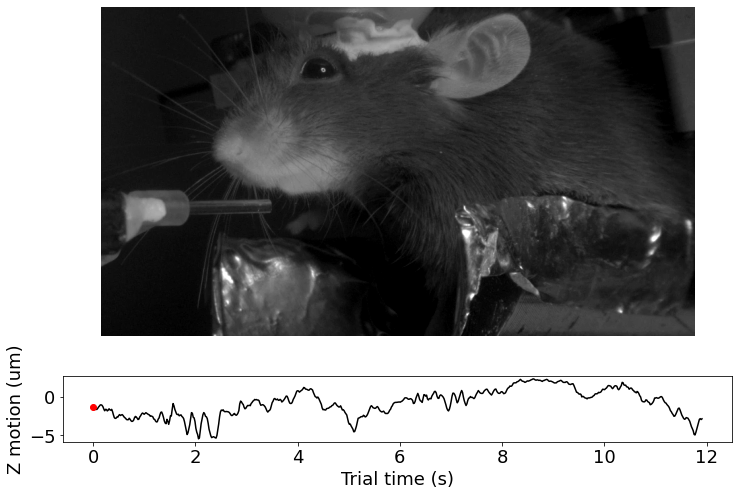

In [138]:
# identify trials with biggest movements
#find movies and extract them
#create movies of trials with biggest movements
import cv2
from matplotlib.gridspec import GridSpec
import subprocess
import shutil
save_dir = '/home/jupyter/temp/video'



label_to_use = 'rigid_z_offset_fit'
for session_i,session in enumerate(sessions):
    time_trace = np.arange(len(indices))/data_dict[session]['sampling_rate'] + indices[0]/data_dict[session]['sampling_rate'] 

    trace_now = np.asarray(data_dict[session][label_to_use].copy(),float)
    trace_filt= BCI_analysis.plot_utils.rollingfun(trace_now.copy(),5)
    tace_baseline = BCI_analysis.plot_utils.rollingfun(trace_now.copy(),2500,'median')
    trace_now -= tace_baseline
    trace_filt -= tace_baseline
    trial_num_trace = np.zeros(len(trace_now))
    trial_start_end_frames = np.asarray([0] + np.cumsum(data_dict[session]['all_si_frame_nums']).tolist())
    counter = 0
    for i, (sframe,eframe) in enumerate(zip(trial_start_end_frames[:-1],trial_start_end_frames[1:])):
        trial_num_trace[sframe:eframe] = i
    trial_num_trace = np.asarray(trial_num_trace,int)

    trial_num_order = trial_num_trace[np.argsort(np.abs(trace_filt))[::-1]]
    decreasing_max_amplitude_trials = []
    while len(trial_num_order)>0:
        decreasing_max_amplitude_trials.append(trial_num_order[0])
        trial_num_order = trial_num_order[trial_num_order!=trial_num_order[0]]
    


    camera = "side"
    setup = 'Bergamo-2P-Photostim'
    bpod_filepath = os.path.join(bpod_path, setup,subject, session+"-bpod_zaber.npy")
    bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()
    behavior_movie_names_ = bpod_data['behavior_movie_name_list']

    files_with_movies = []
    behavior_movie_names = bpod_data['behavior_movie_name_list']
    for i, k in enumerate(bpod_data['scanimage_file_names']):
        # print(k)
        if str(k) == 'no movie for this trial':
            files_with_movies.append(False)
        else:
            files_with_movies.append(True)                        
    behavior_movie_names = behavior_movie_names[files_with_movies]
    for i_ in decreasing_max_amplitude_trials[:3]: #i_ is total scanimage file  num
        si_filename = data_dict[session]['all_si_filenames'][i_]
        for i,sifname in enumerate(data_dict[session]['scanimage_filenames']):# i is actual trial num
            if si_filename in sifname :
                break
        bm_name = behavior_movie_names[i]

        if type(bm_name) == str:
            print(f"{camera} camera not found for trial {i}, skipping")
            continue

        camera_movies = []
        for video_file in bm_name:
            if camera in video_file: 
                camera_movies.append(video_file)

        if len(camera_movies) == 0:
            print(f"{camera} camera not found for trial {i}, skipping")
            continue
        elif len(camera_movies) > 1:
            print(f"Multiple {camera} camera files found for trial {i}, skipping")
            continue
        bmn = camera_movies[0]
        residual_path = bmn[bmn.find(camera):].strip("'")
        video_path = os.path.join(raw_video_path,residual_path)
        trial_json = video_path[:-4]+".json"
        with open(trial_json) as f:
            trial_metadata = json.load(f) 
        frame_times_facemovie = np.asarray(trial_metadata['frame_times'])

        # find frame number in trial
        frame_times_ca = np.arange(0, data_dict[session]['all_si_frame_nums'][i_], 1, dtype=float)/data_dict[session]['sampling_rate']
        needed_indices = []
        for t in frame_times_ca: # TODO # downsample facerhythm here.. it was downsampled in a stupid way so I have to do a stupid fix
            needed_indices.append(np.argmin(np.abs(t-frame_times_facemovie)))

        cap = cv2.VideoCapture(video_path)
        frame_i=-1
        face_movie =[]
        while(cap.isOpened()):
            ret, frame = cap.read()
            frame_i+=1
            if ret == True:
                if frame_i in needed_indices:
                    face_movie.append(frame[:,:,0])  
            else: 
                break   
        cap.release()

        video_name = '{}_{}_{}'.format(subject,session,os.path.split(residual_path)[-1])
        #save_dir = '/home/jupyter/temp/video'
        all_frames = np.asarray(face_movie)
        start_idx = np.sum(data_dict[session]['all_si_frame_nums'][:i_])
        end_idx = start_idx + data_dict[session]['all_si_frame_nums'][i_]
        z_trace_now = trace_filt[start_idx:end_idx]
        fig = plt.figure(figsize = [12,8])

        p2_pixel_range = 200

        gs1 = GridSpec(2, 1, height_ratios=[5, 1])#,width_ratios = [3,4])
        ax_trace = fig.add_subplot(gs1[1, 0])

        ax_face = fig.add_subplot(gs1[0, 0])
        plt.set_cmap('gray')
        clims_video = np.percentile(all_frames.flatten(),[5,99.99])

        for frame in np.arange(len(z_trace_now)):

            ax_faceimage.cla()
            im_face = ax_face.imshow(all_frames[frame])#[:400,100:])
            im_face.set_clim(clims_video)
            ax_face.axis('off')

            ax_trace.cla()
            ax_trace.plot(frame_times_ca,z_trace_now,'k-')
            ax_trace.plot(frame_times_ca[frame],z_trace_now[frame],'ro')
            ax_trace.set_xlabel('Trial time (s)')
            ax_trace.set_ylabel('Z motion (um)')
            plt.savefig(save_dir + "/file%02d.png" % frame)


        plt.close()
        gc.collect()
        os.chdir(save_dir)
        subprocess.call([
            'ffmpeg', '-framerate', '60', '-i', 'file%02d.png', '-r', '60', '-pix_fmt', 'yuv420p',
            '{}'.format(video_name)
        ])
        for file_name in os.listdir(save_dir):
            if '.png' in file_name:
                os.remove(file_name)
        shutil.move(os.path.join(save_dir,video_name),os.path.join('/home/jupyter/bucket/',video_name))


    
    

In [139]:
plt.savefig(save_dir + "/file%02d.png" % frame)

<Figure size 432x288 with 0 Axes>

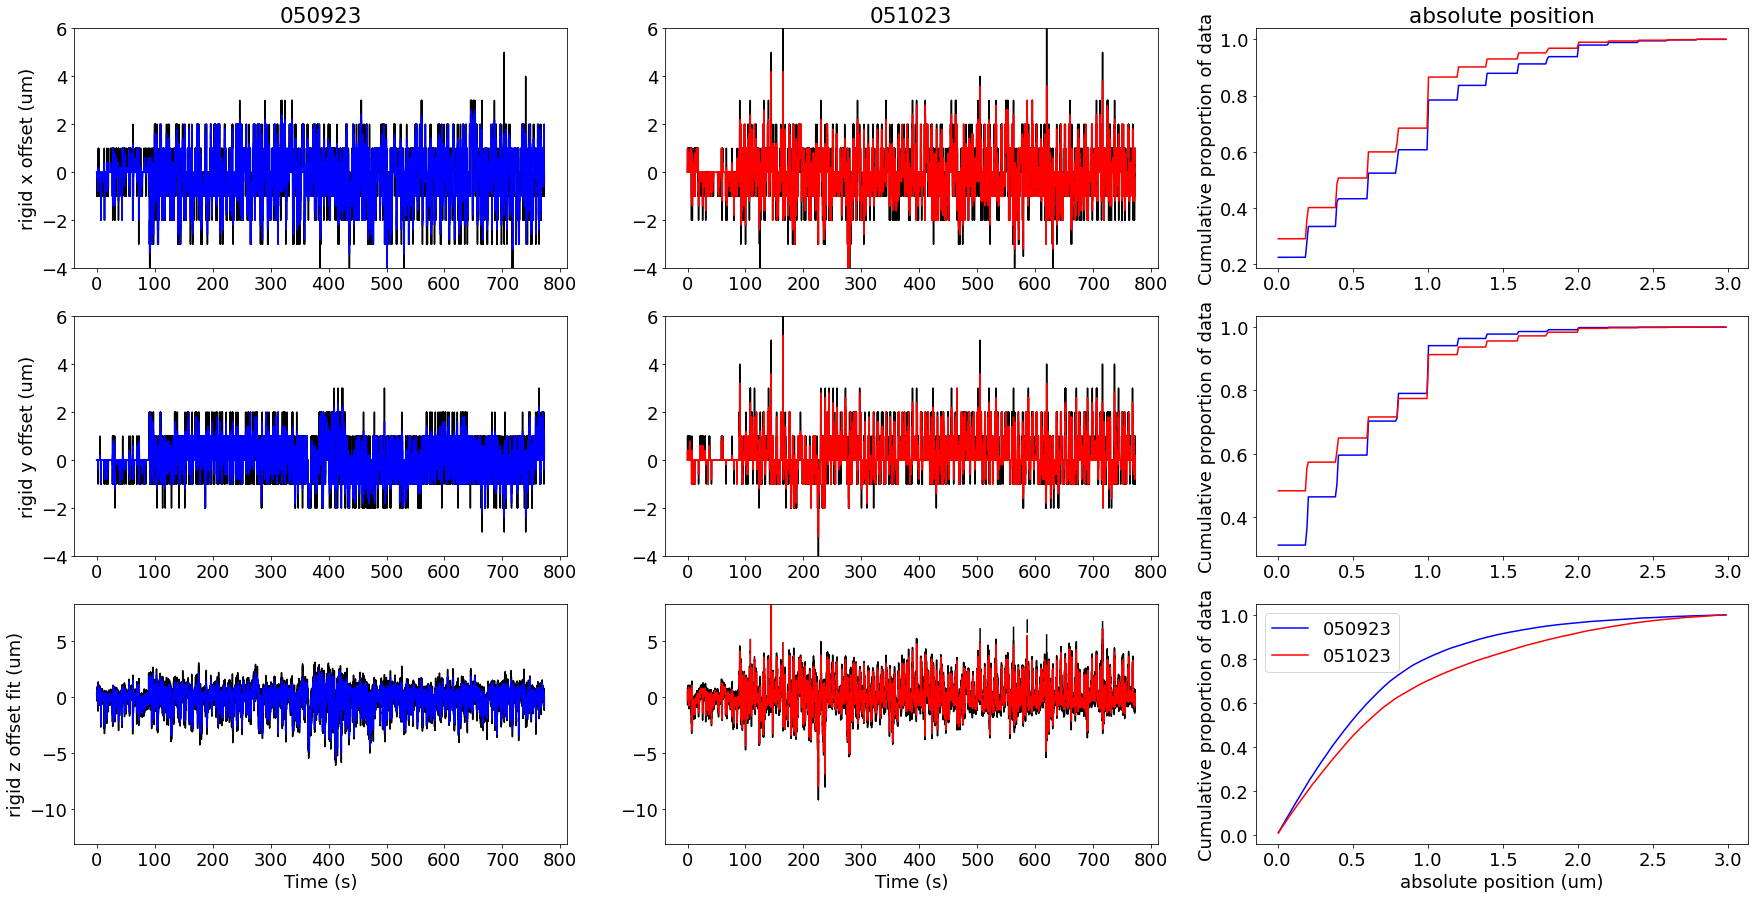

<Figure size 2160x1080 with 0 Axes>

In [20]:
fig = plt.figure(figsize = [30,15])
fig_histograms = plt.figure(figsize = [30,15])
histogram_range = np.arange(0,3,.01)
histogram_diff_range = np.arange(0,.5,.001)*data_dict[session]['sampling_rate'] 
histogram_bins = np.nanmean([histogram_range[1:],histogram_range[:-1]],0)
histogram_diff_bins = np.nanmean([histogram_diff_range[1:],histogram_diff_range[:-1]],0)
movement_labels = ['rigid_x_offset',
                   'rigid_y_offset',
                   #'rigid_z_offset_raw',
                   'rigid_z_offset_fit']
time_edges = [0,45000]
#time_edges = [38000,40000]
#time_edges = [22000,24000]
indices = np.arange(time_edges[0],time_edges[1])
ax_list = []
ax_hist_list = []
ax_hist_list_diff = []
colors = ['blue','red']
for session_i,session in enumerate(sessions):
    time_trace = np.arange(len(indices))/data_dict[session]['sampling_rate'] + indices[0]/data_dict[session]['sampling_rate'] 
    for label_i,m in enumerate(movement_labels):
        if session_i == 0:
            ax = fig.add_subplot(len(movement_labels),len(sessions)+1,(label_i)*(len(sessions)+1)+session_i+1)
            
            ax_list.append(ax)
            ax.set_ylabel(m.replace('_',' ') + (' (um)'))
            ax_hist = fig.add_subplot(len(movement_labels),len(sessions)+1,(label_i)*(len(sessions)+1)+len(sessions)+1) # last column
            ax_hist_list.append(ax_hist)
            ax_hist.set_ylabel('Cumulative proportion of data')      
            # ax_hist_diff = fig.add_subplot(len(movement_labels),len(sessions)+2,(label_i)*(len(sessions)+2)+len(sessions)+2) # last column
            # ax_hist_list_diff.append(ax_hist_diff)
        else:
            ax = fig.add_subplot(len(movement_labels),len(sessions)+1,(label_i)*(len(sessions)+1)+session_i+1,sharex = ax_list[label_i],sharey = ax_list[label_i])
            
            ax_hist = ax_hist_list[label_i]
            # ax_hist_diff = ax_hist_list_diff[label_i]
        trace_now = np.asarray(data_dict[session][m].copy(),float)
        trace_filt= BCI_analysis.plot_utils.rollingfun(trace_now.copy(),5)
        tace_baseline = BCI_analysis.plot_utils.rollingfun(trace_now.copy(),2500,'median')
        trace_now -= tace_baseline
        trace_filt -= tace_baseline

        ax.plot(time_trace,trace_now[indices],'k-')
        ax.plot(time_trace,trace_filt[indices],'-',color = colors[session_i])
        ax.autoscale(enable=True, axis='x', tight=True)
        if label_i == 0:
            ax.set_title(session)
            # ax_hist_diff.set_title('absolute speed')
            ax_hist.set_title('absolute position')
        if label_i == len(movement_labels)-1:
            ax.set_xlabel('Time (s)')
            # ax_hist_diff.set_xlabel('speed (um/s)')
            ax_hist.set_xlabel('absolute position (um)')
        hist_vals,x = np.histogram(np.abs(trace_filt),histogram_range)
        ax_hist.plot(histogram_bins,np.cumsum(hist_vals)/sum(hist_vals),color=colors[session_i],label = session)
        
        # hist_vals,x = np.histogram(np.abs(np.diff(trace_filt))*data_dict[session]['sampling_rate'] ,histogram_diff_range)
        # ax_hist_diff.plot(histogram_diff_bins,np.cumsum(hist_vals)/sum(hist_vals),color=colors[session_i],label = session)
        
ax_hist.legend()

0
0
0
0
0
0


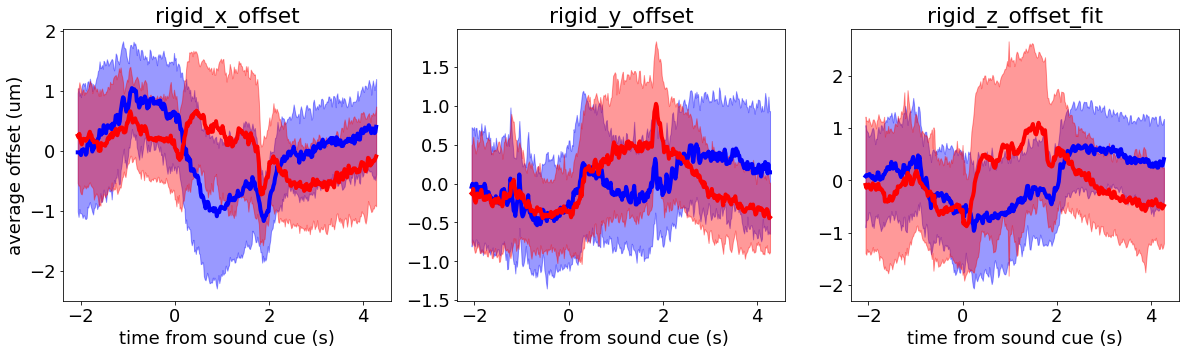

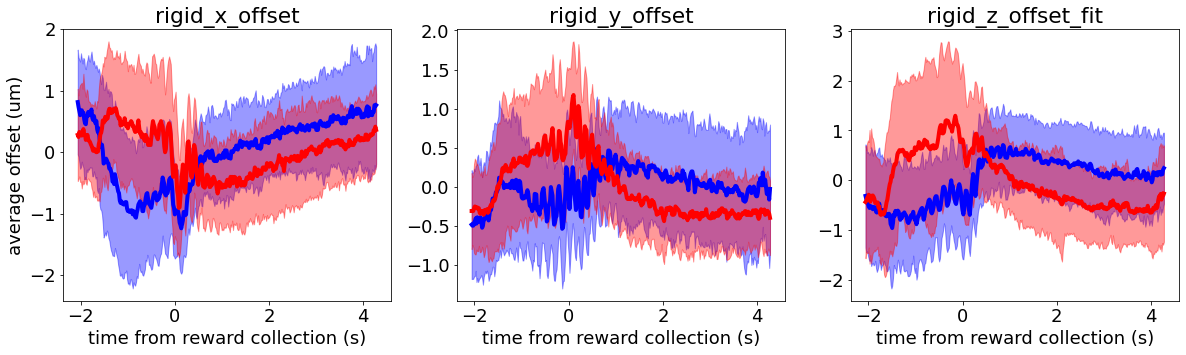

In [7]:
import importlib 
importlib.reload(BCI_analysis)

#import BCI_analysis
step_back = 120
step_forward = 250

time_vector = np.arange(-step_back,step_forward)/data_dict[session]['sampling_rate']
dff_go_cue_locked = []
dff_reward_locked = []
dff_reward_lick_locked = []
movement_labels = ['rigid_x_offset',
                   'rigid_y_offset',
                  # 'rigid_z_offset_raw',
                   'rigid_z_offset_fit']
session_lens = []
for session in sessions:
    needed_list = []
    for f in data_dict[session]['scanimage_filenames']:
        if len(f)==1:
            needed_list.append(True)
        else:
            needed_list.append(False)
            #f_new.append([f[0]])
    needed_list = np.asarray(needed_list)
    dff_now = []
    for m in movement_labels:
        trace_now = np.asarray(data_dict[session][m].copy(),float)
        #trace_filt= BCI_analysis.plot_utils.rollingfun(trace_now,10)
        tace_baseline = BCI_analysis.plot_utils.rollingfun(trace_now,2500,'median')
        trace_now -= tace_baseline
        #trace_filt -= tace_baseline
        
        dff_now.append(trace_now)
    dff_now = np.asarray(dff_now) 
    dff_now[np.isnan(dff_now)] = 0 # HAVE TO KILL NANs
    
    
    #print(data_dict[session]['scanimage_filenames'])
    
    
    dff_go_cue_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                                            data_dict[session]['all_si_filenames'],
                                                                            data_dict[session]['scanimage_filenames'][needed_list],
                                                                            data_dict[session]['all_si_frame_nums'],
                                                                            data_dict[session]['sampling_rate'],
                                                                            'go_cue',
                                                                            data_dict[session]['go_cue_times'][needed_list],
                                                                            data_dict[session]['reward_times'][needed_list],
                                                                            max_frames=None,
                                                                            frames_after=step_forward,
                                                                            frames_before=step_back)
    dff_reward_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                                            data_dict[session]['all_si_filenames'],
                                                                            data_dict[session]['scanimage_filenames'][needed_list],
                                                                            data_dict[session]['all_si_frame_nums'],
                                                                            data_dict[session]['sampling_rate'],
                                                                            'reward',
                                                                            data_dict[session]['go_cue_times'][needed_list],
                                                                            data_dict[session]['reward_times'][needed_list],
                                                                            max_frames=None,
                                                                            frames_after=step_forward,
                                                                            frames_before=step_back)
    dff_reward_lick_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                                            data_dict[session]['all_si_filenames'],
                                                                            data_dict[session]['scanimage_filenames'][needed_list],
                                                                            data_dict[session]['all_si_frame_nums'],
                                                                            data_dict[session]['sampling_rate'],
                                                                            'reward',
                                                                            data_dict[session]['go_cue_times'][needed_list],
                                                                            np.asarray(data_dict[session]['reward_collecting_lick_times'])[needed_list],
                                                                            max_frames=None,
                                                                            frames_after=step_forward,
                                                                            frames_before=step_back)
    session_lens.append(dff_reward_lick_locked_.shape[2])
    dff_go_cue_locked.append(dff_go_cue_locked_)
    dff_reward_locked.append(dff_reward_locked_)
    dff_reward_lick_locked.append(dff_reward_lick_locked_)
    #break
# dff_go_cue_locked = np.concatenate(dff_go_cue_locked,2)
# dff_reward_locked = np.concatenate(dff_reward_locked,2)
# dff_reward_lick_locked = np.concatenate(dff_reward_lick_locked,2)




optimal_k = len(movement_labels)

fig = plt.figure(figsize = [20,5])
#fig_all_traces = 
offset = 0
ax_list = []
for session_i,(session_matrix,color) in enumerate(zip(dff_go_cue_locked,['blue','red'])):
    for group_i in np.arange(optimal_k):
        if session_i == 0:
            ax_now = fig .add_subplot(1,optimal_k,group_i+1)
            ax_now.set_title(movement_labels[group_i])
            ax_list.append(ax_now)
        else:
            ax_now = ax_list[group_i]
            
        reward_traces_now = session_matrix[:,group_i,:].squeeze()
        trace_now = np.nanmean(reward_traces_now,1)
        trace_now_std = np.nanstd(reward_traces_now,1)
        trace_now = trace_now-np.nanmean(trace_now)
        ax_now.plot(time_vector,trace_now+offset,'-',color = color,linewidth = 4,alpha = 1)
        ax_now.fill_between(time_vector,trace_now+offset+trace_now_std, trace_now+offset-trace_now_std,color = color,alpha = .4)
        #offset += np.nanmax(trace_now)
        print(offset)
        ax_now.set_xlabel('time from sound cue (s)')
        if group_i == 0:
            
            ax_now.set_ylabel('average offset (um)')
    
fig = plt.figure(figsize = [20,5])
#fig_all_traces = 
offset = 0
ax_list = []
for session_i,(session_matrix,color) in enumerate(zip(dff_reward_lick_locked,['blue','red'])):
    for group_i in np.arange(optimal_k):
        if session_i == 0:
            ax_now = fig .add_subplot(1,optimal_k,group_i+1)
            ax_now.set_title(movement_labels[group_i])
            ax_list.append(ax_now)
        else:
            ax_now = ax_list[group_i]
            
        reward_traces_now = session_matrix[:,group_i,:].squeeze()
        trace_now = np.nanmean(reward_traces_now,1)
        trace_now = trace_now-np.nanmean(trace_now)
        trace_now_std = np.nanstd(reward_traces_now,1)
        
        ax_now.plot(time_vector,trace_now+offset,'-',color = color,linewidth = 4,alpha = 1)
        ax_now.fill_between(time_vector,trace_now+offset+trace_now_std, trace_now+offset-trace_now_std,color = color,alpha = .4)

        #offset += np.nanmax(trace_now)
        
        ax_now.set_xlabel('time from reward collection (s)')
        if group_i == 0:
            
            ax_now.set_ylabel('average offset (um)')
    #break
            


In [54]:
camera_movies

[" '/home/labadmin/Data/Behavior_videos/side/pkj04/2023-05-09_12-25-20/trial_00000__2023-05-09_12-25-20.mp4'"]

In [75]:
sifname

array(['conditioning_00030.tif'], dtype='<U22')

NameError: name 'asd' is not defined

'trial_00009__2023-05-10_09-29-18.mp4'